# Basics of mobile robotics project report

### This project has been done by:

* Raphael Linsen 322824
* Pierre-Vincent Naayem 257676
* Nathan Laroche 270509
* Yanis Bouadi 283606

# Digital library use for this project

In [1]:
import cv2
import math
from math import cos, sin, degrees, radians
import numpy as np
import matplotlib.pyplot as plt
import MTM
from MTM import matchTemplates, drawBoxesOnRGB
from scipy import ndimage, misc
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from myThymio import MyThymio
from utils import *
from myThymio.thymio_constants import *

# Introduction

The goal of this project is to code a program for a robot. The objective is going from a point A to a point B and avoid the obstacles even the least expected one.

Here, our group choose to make the thymio lie on a chess board where we take one picture of the board with the obstacles, the thymio and the destination. Thus we can find the global path that should take the thymio in order to arrive at destination and avoid the obstacles.

Then, in order to know his position on the board at each time, we decide to implement a particle filter with odometry programm

Finally to avoid unexpected obstacles on the path, we implement a local avoidance program based on a potential approach.

# 1. Vision

Take the picture using the camera

True

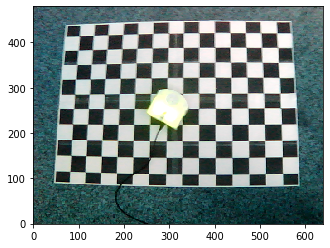

In [26]:
camera = cv2.VideoCapture(0)

img = None
while True:
    return_value, current_image = camera.read()
    gray = cv2.cvtColor(current_image,cv2.COLOR_BGR2GRAY)
    cv2.imshow('image',gray)
    if cv2.waitKey(1)& 0xFF == ord('s'):
        img = current_image[::-1,:,:]
        break
camera.release()
cv2.destroyAllWindows()
plt.imshow(img, origin='lower')

## Cropping and resizing of the image

### Image processing for the board

In [10]:
# cv2.imwrite('images/terrain.jpg', img)
# img = cv2.imread('images/terrain.jpg')[::-1,:,:]

#Erase black cells
img_no_black = remove_black(img, 65)


#Add a blur on the image to better isolated the board
kernel_size = 41
blurred_img = cv2.GaussianBlur(img_no_black,(kernel_size,kernel_size),0)

#Threshold on the processed image to get the board with a choice 
# between the 3 main colors to adapt to the luminosity or the color 
# of the obstacles on the image

threshold_val = 200
(b, g, r) = cv2.split(blurred_img)
_,threshold = cv2.threshold(r, threshold_val, 255,  
                            cv2.THRESH_BINARY) 

# Get the vertices of the the threshold image 
board = find_rectangle(threshold, 100000, 0.04)

NameError: name 'remove_black' is not defined

Plot of the thresholded image 

In [ ]:
plt.imshow(blurred_img, origin='lower')
plt.figure()
plt.imshow(threshold, origin='lower')

### Rescale the 3D board image to a 2D board image 

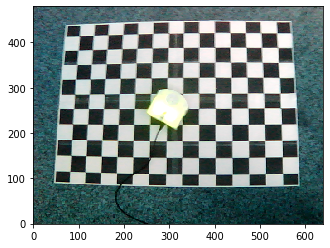

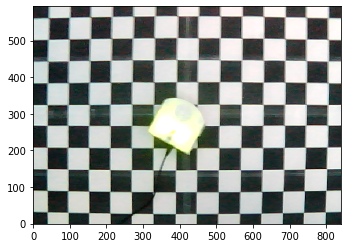

In [63]:
def crop(image, rectangle):
    pts0 = np.float32(board)

    W, H = 420*2, 297*2
    # Define corresponding points in output image
    pts1 = np.float32([[0,0],[0,H],[W,H],[W,0]])

    # Get perspective transform and apply it
    M = cv2.getPerspectiveTransform(pts0,pts1)
    rescaled_img = cv2.warpPerspective(image,M,(W,H))
    return rescaled_img

rescaled_img = crop(img, board)

Plot of the resized image with only the board 

In [ ]:
plt.imshow(img, origin='lower')
plt.figure()
plt.imshow(rescaled_img, origin='lower')

## Location of the thymio and the goal using pattern matching

Template chose for the Thymio

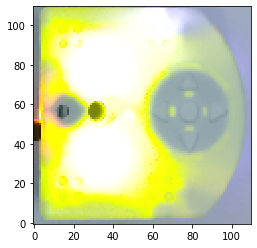

In [64]:
thymio_template = cv2.resize(cv2.imread('images/thymio.jpg')[::-1,:,:], dsize=(110, 110), interpolation=cv2.INTER_CUBIC)
plt.imshow(thymio_template, origin='lower')

Template chose for the Destination

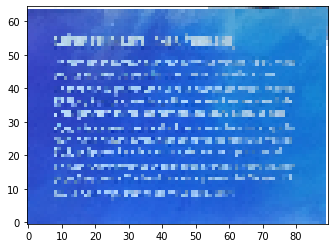

In [65]:
goal_template = cv2.resize(cv2.imread("images/destination.png")[::-1,:,:], dsize=(90, 65), interpolation=cv2.INTER_CUBIC)
plt.imshow(goal_template, origin='lower')

### Find an object on a map

In [66]:
def find_object(template, rescaled_img, angle_resolution):
    best_angle = 0
    best = 0
    best_Hit = []
    for angle in np.arange(0, 359, angle_resolution):
        rotated = ndimage.rotate(template, angle) 
        name = "".join(["thymio_", str(angle)])
        listTemplate = [(name, rotated)]
        Hit = matchTemplates(listTemplate, rescaled_img,method=cv2.TM_CCOEFF_NORMED, N_object=1,score_threshold=0.1, maxOverlap=0,searchBox=None)
        if Hit.Score.to_numpy()[0] > best:
            best_Hit = Hit
            best_angle = angle
            best = Hit.Score.to_numpy()[0]
    
    corner = best_Hit.BBox.to_numpy()[0][0:2]
    size_hit = best_Hit.BBox.to_numpy()[0][2:4]
    center = np.array(corner) + np.array(size_hit)/2
    
    angle = radians(best_angle)
    return center, angle

Find the thymio and the destination images centers

In [67]:
#Thymio
thymio_center, thymio_angle = find_object(thymio_template, rescaled_img, 2)

#Goal
goal_center, _ = find_object(goal_template, rescaled_img, 10)

Find the center of the wheels for the thymio

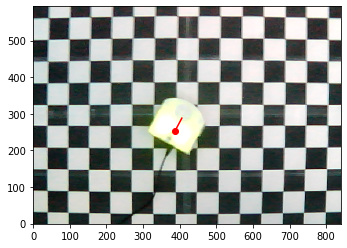

In [68]:
# Find the center of the wheels of the Thymio
theta = thymio_angle
forward = np.array([-cos(theta), sin(theta)])
wheel_center = thymio_center + forward*20

# Save the position of the thymio
thymio_pos = (wheel_center[0], wheel_center[1] , -theta)

Plot of the position pf the thymio and his wheels and the destination on the chess board

In [ ]:
plt.imshow(rescaled_img, origin='lower')
plt.scatter(wheel_center[0], wheel_center[1], c='r')
x, y = wheel_center
length = 40
plt.plot((x, x + length * math.cos(-theta)), (y, y + length * math.sin(-theta)), "r")

## Generation of the obstacle  map

Remove black pattern in the background

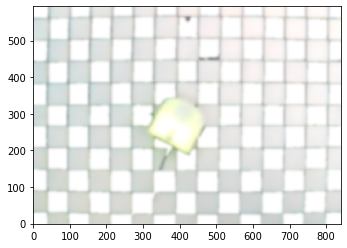

In [69]:
#Add a bilateral filter to avoid noise
filtered_img = cv2.bilateralFilter(rescaled_img,21, 75, 75)

filtered_img = remove_black(filtered_img, 100)
kernel_size = 21
filtered_img = cv2.GaussianBlur(filtered_img,(kernel_size,kernel_size),0)

plt.imshow(filtered_img, origin='lower')

### Image processing filter

In [11]:
#Value of the threshold such we can isolated the edges of obstacles

threshold_val = 170

#Choose a color-based filter with a threshold such that we can isolated well
#the obstacles despite the noise or the luminosity

(b, g, r) = cv2.split(filtered_img)
ret2, thresh2 = cv2.threshold(b, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret3, thresh3 = cv2.threshold(g, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret4, thresh4 = cv2.threshold(r, threshold_val, 255, cv2.THRESH_BINARY_INV)
bgr_thresh = cv2.merge((thresh2, thresh3, thresh4))

black_and_white = thresh3

plt.imshow(black_and_white, cmap='Greys', origin='lower')

# Detecting shapes in image by selecting region with same colors or intensity

contours,_=cv2.findContours(black_and_white, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

obstacles =  []

# Searching through every region selected to find the required polygon

for cnt in contours : 
    area = cv2.contourArea(cnt) 
   
    # Shortlisting the regions based on there area 
    if area > 2000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.03 * cv2.arcLength(cnt, True), True) 
        obstacles.append(approx)
    else:
        cv2.drawContours(black_and_white, [cnt], -1, 0, thickness=-1)
    
plt.figure()

plt.imshow(black_and_white, cmap='Greys', origin='lower')

obstacle_map = black_and_white

#Function that return the norm of the vector

from numpy import sqrt
def norm(vec):
    return sqrt(vec[0]**2 + vec[1]**2)

#Margin that we use to avoid obstacles applied to each nodes

MARGIN = 90

way_points = []

# Find the edges or each obstacles and then put nodes in circular arc
# at a confortable distance to avoid it and then we plot them on the 
# processed image

for obstacle in obstacles:
    n= len(obstacle)
    for i in range(n):
        vertice1 = obstacle[i][0]
        vertice2 = obstacle[(i+1)%n][0]
        vertice3 = obstacle[(i+2)%n][0]
        
        vec1 = vertice2 - vertice1
        vec2 = vertice2 - vertice3
        
        normal_vec = vec1/norm(vec1) + vec2/norm(vec2)
        way_point1 = vertice2 + vec1*MARGIN/norm(vec1)
        way_point2 = vertice2 + vec2*MARGIN/norm(vec2)
        way_point3 = vertice2 + normal_vec*MARGIN/norm(normal_vec)
        
        way_points.append(way_point1)
        way_points.append(way_point2)
        way_points.append(way_point3)
        
        plt.scatter(way_point1[0], way_point1[1], c='r')
        plt.scatter(way_point2[0], way_point2[1], c='r')
        plt.scatter(way_point3[0], way_point3[1], c='r')
        plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')

NameError: name 'cv2' is not defined

# 2. Global navigation



## Graph generation

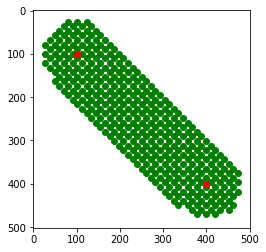

In [71]:
# Function to avoid the thymio to go out of the board

def sample_image(obstacle_map, x, y):
    max_y = obstacle_map.shape[0]
    max_x = obstacle_map.shape[1]
    if x >= max_x or x < 0 or y >= max_y or y < 0:
        return 255
    else:
        return obstacle_map[y][x]

# Function that find if there is any obstacle between two consecutives nodes

def noObstacleBetween(obstacle_map, p1, p2, plot=False):
    RESOLUTION = 15
    
    x, y = p1
    x_end, y_end = p2
    forward = np.array([x_end - x, y_end - y])
    
    dist = np.linalg.norm(forward)
    if dist == 0:
        return False
    
    forward = forward/dist
    perp = np.array([forward[1], -forward[0]])
    
    MARGIN2 = MARGIN*0.9
    
    for perp_dist in np.arange(-MARGIN2, MARGIN2, RESOLUTION):
        for forward_dist in np.arange(-MARGIN2, dist + MARGIN2, RESOLUTION):
            if forward_dist < 0 and sqrt(perp_dist**2 + forward_dist**2) >= MARGIN2:
                continue
            if forward_dist > dist and sqrt(perp_dist**2 + (forward_dist-dist)**2) >= MARGIN2:
                continue
                
            sample_point = np.array(p1) + forward_dist*forward + perp_dist*perp
            
            if plot:
                plt.scatter(sample_point[0], sample_point[1], c='g')
                
            intensity = sample_image(obstacle_map, int(sample_point[0]), int(sample_point[1]))
            if intensity == 255:
                return False
            
            
    return True

noObstacleBetween(np.zeros((600, 600)), p1, p2, plot=True)

Output the map with nodes

In [ ]:
plt.imshow(np.zeros((100, 100)), cmap='Greys')
p1 = (100, 100)
p2 = (400, 400)
plt.scatter([p1[0], p2[0]], [p1[1], p2[1]], c='r')

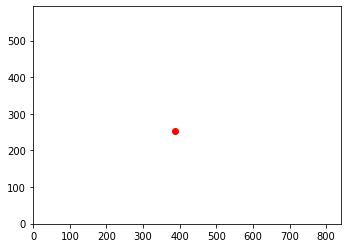

In [72]:
import itertools

# Create a class for each node

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.gScore = np.inf
        self.fScore = np.inf
        self.neighbours = []
    def plot(self, color = 'r'):
        plt.scatter(self.x, self.y, c=color)
    def get_pos(self):
        return self.x, self.y
    def __repr__(self):
        return "node ("+str(self.x)+","+str(self.y)+")"
    
#Create a clase for the graph of the map

class Graph:
    def __init__(self, way_points, obstacle_map):
        self.obstacle_map = obstacle_map
        self.nodes = []
        for way_point in way_points:
            x, y = way_point
            self.nodes.append(Node(x, y))
        for node1, node2 in itertools.combinations(self.nodes, 2):
            if noObstacleBetween(self.obstacle_map, node1.get_pos(), node2.get_pos()):
                node1.neighbours.append(node2)
                node2.neighbours.append(node1)

                x, y = node1.get_pos()
                x_end, y_end = node2.get_pos()
                plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
                
    def add_new_node(self, node):
        for potential_neighbour in self.nodes:
            if noObstacleBetween(self.obstacle_map, node.get_pos(), potential_neighbour.get_pos()):
                node.neighbours.append(potential_neighbour)
                potential_neighbour.neighbours.append(node)
                
#                 x, y = node.get_pos()
#                 x_end, y_end = potential_neighbour.get_pos()
#                 plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
        self.nodes.append(node)
    
plt.imshow(obstacle_map, cmap='Greys', origin='lower')
graph = Graph(way_points+[(thymio_pos[0], thymio_pos[1])], obstacle_map)

Graph output

In [ ]:
for node in graph.nodes:
    node.plot()

## Path finding using A*

In [73]:
# Evaluate the distance 

def distance(node1, node2):
    return sqrt((node1.x-node2.x)**2 + (node1.y - node2.y)**2)

### Path computation by using a A* algorithm

def A_Star(start, goal, h):
    for node in graph.nodes:
        node.gScore = np.inf
        node.fScore = np.inf
    
    openSet = [start]
    start.gScore = 0
    closedSet = []
    
    cameFrom = dict()
    
    while openSet != []:
        current = min(openSet, key=lambda node: node.fScore)
        if current == goal:
            path = [current]
            while current in cameFrom.keys():
                path.insert(0, cameFrom[current]) 
                current=cameFrom[current]
            return path, closedSet
        
        openSet.remove(current)
        closedSet.append(current)
        
        for neighbour in current.neighbours:
            if neighbour in closedSet:
                continue
                
            tentative_gScore = current.gScore + distance(current, neighbour)
            
            if neighbour not in openSet:
                openSet.append(neighbour)
            
            if tentative_gScore < neighbour.gScore:
                cameFrom[neighbour] = current
                neighbour.gScore = tentative_gScore
                neighbour.fScore = neighbour.gScore + h(neighbour)
    print("No path found to goal")
    return None, closedSet

#Function to compute the optimal path

def compute_path(start, goal, graph):
    graph.add_new_node(start)
    graph.add_new_node(goal)
    
    h = lambda node: distance(node, goal)
    path_nodes, closedSet = A_Star(start, goal, h)
    
    path = []
    for node in path_nodes:
        x, y = node.get_pos()
        path.append((x, y, 0))
    
    # Draw
    for node in graph.nodes:
        node.plot()
    for node in closedSet:
        node.plot('m')
    if path!=None:
        for i in range(len(path_nodes)-1):
            x, y = path_nodes[i].get_pos()
            x_end, y_end = path_nodes[i+1].get_pos()
            plt.plot((x, x_end), (y, y_end), 'g', linewidth=3)
    start.plot('g')
    goal.plot('b')
    
    return path


Optimal global path output

NameError: name 'destination' is not defined

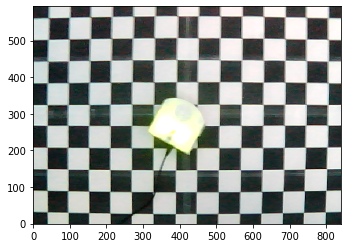

In [74]:
plt.imshow(rescaled_img, cmap='Greys', origin='lower')

start = Node(thymio_pos[0], thymio_pos[1])
goal = Node(destination[0], destination[1])

path = compute_path(start, goal, graph)

# Filtering

### Particle filter algorithm

In [75]:
# %load -n particle_filter
def particle_filter(
    particle_pos_list, speed_left_m, speed_right_m, ground_left_measure, ground_right_measure, dt
):
    weights = np.empty([NUMBER_OF_PARTICLES * NEW_GEN_NUMBER])

    new_generation = []
    i = 0
    for particle_pos in particle_pos_list:
        for _ in range(NEW_GEN_NUMBER):
            # Create the new generation using the motion uncertainty model
            speed_left = np.random.normal(speed_left_m, SIGMA_V)
            speed_right = np.random.normal(speed_right_m, SIGMA_V)
            new_pos = update_pos(particle_pos, speed_left, speed_right, dt)
            new_generation.append(new_pos)

            # Estimate the probability of the measurement if the robot was at this position, and use it as weight
            weights[i] = ground_measurement_probability(new_pos, ground_left_measure, ground_right_measure)

            i += 1

    # Sample the new generation according to the weights
    indices = range(len(new_generation))
    sample = np.random.choice(indices, size=NUMBER_OF_PARTICLES, replace=True, p=weights / np.sum(weights))

    new_particles = [new_generation[i] for i in sample]

    return new_particles

### Show difference between odometry and particle filter

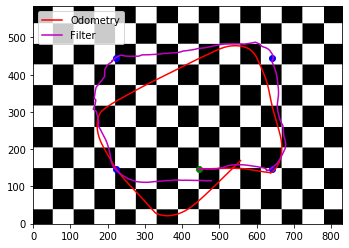

In [76]:
import json

# Read the data from the file
with open('saved_data.txt', 'r') as filehandle:
    (path, initial_pos, saved_data) = json.load(filehandle)

pos_odometry = initial_pos

NUMBER_OF_PARTICLES = 70
particle_pos_list = [initial_pos for _ in range(NUMBER_OF_PARTICLES)]

odometry_pos_history = np.array((initial_pos[0], initial_pos[1]))
filter_pos_history = np.array((initial_pos[0], initial_pos[1]))
for data in saved_data:
    speed_left, speed_right, ground_left_measure, ground_right_measure, time_diff = data
    
    # Localization using only odometry
    pos_odometry = update_pos(pos_odometry, speed_left * THYMIO_SPEED_TO_MMS, speed_right * THYMIO_SPEED_TO_MMS, time_diff)
    
    # Localization using the filter
    particle_pos_list = particle_filter(
        particle_pos_list, 
        speed_left * THYMIO_SPEED_TO_MMS, speed_right * THYMIO_SPEED_TO_MMS, ground_left_measure, ground_right_measure,
        time_diff)
    pos_filter = np.mean(particle_pos_list, axis=0)
    
    # Save the results to plot afterward
    filter_pos_history = np.vstack((filter_pos_history, (pos_filter[0], pos_filter[1])))
    odometry_pos_history = np.vstack((odometry_pos_history, (pos_odometry[0], pos_odometry[1])))

# Plot the results

for point in path:
    x, y, theta = point
    plt.scatter(x, y, c="b")
    
pattern = get_pattern()
plt.imshow(pattern, cmap="Greys", origin="lower")
plt.scatter(initial_pos[0], initial_pos[1], c='g')
plt.plot(odometry_pos_history[:, 0], odometry_pos_history[:, 1], 'r', label='Odometry')
plt.plot(filter_pos_history[:, 0], filter_pos_history[:, 1], 'm', label='Filter')
plt.legend()

# 3. Control

### Control of the position of the Thymio by using odometry

In [ ]:
# %load -n controller
def controller(current_pos, target_pos):
    x, y, theta = current_pos
    x_d, y_d, theta_d = target_pos

    x_r = x - x_d
    y_r = y - y_d
    rho = sqrt(x_r ** 2 + y_r ** 2)
    gamma = normalize_angle(atan2(y_r, x_r) - theta + pi)
    delta = normalize_angle(gamma + theta + theta_d)

    if gamma == 0:
        gamma = 0.0001

    k1 = 1.2  # affects linear speed
    k2 = 0.8  # affects rotational speed
    k3 = 0  # affects how much getting to the final angle matters

    v = k1 * rho * cos(gamma)**3
    omega = k2 * gamma + k1 * sin(gamma) * cos(gamma) / gamma * (gamma + k3 * delta)

    v = min(50, max(-50, v))
    omega = min(3, max(-3, omega))

    speed_left = (v - WHEELS_SPACING * omega / 2)
    speed_right = (v + WHEELS_SPACING * omega / 2)
    return speed_left, speed_right

# 4. Local Navigation

# 5. Run the code

In [ ]:
TIME_STEP = 0.1
myThymio = MyThymio(port="COM3", initial_pos=thymio_pos, robot_path=path, refreshing_rate=2 * TIME_STEP)
myThymio.run()